# Validation

In [1]:
import os
import util.util_validation as ut_val
from util.util_logging import open_csv_file, create_tsne_md, create_run_md, create_cm_md

### Parameters

In [2]:
exclude_params_dict = {"tag": ["CropSize32", "divergent", "toSlow", "lrAdjust1", "lrAdjust2", "noCosine", "bszAdjust1", "try2"], "dataset": "cifar10"}
keep_params_dict = {"aug": ["colorJitter", "grayscale"], "dataset": ["city_classification_original", "city_classification_original+diff"]}
models_dict, df_modelNames = ut_val.collect_models_dict(epoch="last", dataset_classifier="ignore", exclude_params_dict=exclude_params_dict, keep_params_dict=keep_params_dict)
print(df_modelNames.to_markdown(index=False))

| model_name                                            |
|:------------------------------------------------------|
| SupCon_city_classification_original+diff_cAugSameSAug |
| SupCon_city_classification_original_allAug            |


In [3]:
cuda_device = 2
tsenecuda_venv = "/home/tgottwald/tsnecuda_venv/"

root_model = models_dict["SupCon_city_classification_original+diff_cAugSameSAug"][0]

dataset_classifier = ""

dataset_val = "city_classification_original" # "animals10_diff_-1"
dataset_val_2 = "city_classification_diff" # "animals10_diff_4000"


tsenecuda_venv_lib64 = os.path.join(tsenecuda_venv, "lib64")
tsenecuda_venv_interpreter = os.path.join(tsenecuda_venv, "bin/python")

root_train, root_test = ut_val.get_root_dataset(dataset_val)
aug_dict = ut_val.get_dataset_augmentations(dataset_val)

if dataset_val_2:
    root_train_2, root_test_2 = ut_val.get_root_dataset(dataset_val_2)
    aug_dict_2 = ut_val.get_dataset_augmentations(dataset_val_2)
    path_folder, path_embeddings, path_embeddings_2, epoch = ut_val.get_paths_from_model_checkpoint(root_model, dataset_val, dataset_val_2)
else:
    path_folder, path_embeddings, epoch = ut_val.get_paths_from_model_checkpoint(root_model, dataset_val)

params = open_csv_file(os.path.join(path_folder, "params.csv"))

### Classifier

In [12]:
if 'method' in params:
    if '+' in params["dataset"]:
        dataset_class_1 = params["dataset"].split("+")[0]
        dataset_class_2 = '_'.join(dataset_class_1.split('_')[:-1]) + '_' + params["dataset"].split("+")[-1]

        root_class_train, root_class_test = ut_val.get_root_dataset(dataset_class_1)
        root_class_train_2, _ = ut_val.get_root_dataset(dataset_class_2)

        num_classes = len(ut_val.get_classes(dataset_class_1))
    else:
        root_class_train, root_class_test = ut_val.get_root_dataset(params["dataset"])
        root_class_train_2 = None

        num_classes = len(ut_val.get_classes(params["dataset"]))

    mean = params['mean']
    std = params['std']

    aug_map = {"sameResizedCrop": "resizedCrop", "sameHorizontalFlip": "horizontalFlip", "sameColorJitter": "colorJitter", "sameGrayscale": "grayscale"}
    aug_str = " ".join([(aug_map[a] if a in aug_map else a) for a in params["aug"]])
    resizedCrop_str = " ".join([str(x) for  x in params["resizedCrop"]])
    colorJitter_str = " ".join([str(x) for x in params["colorJitter"]])


    classifier_training_call = f'CUDA_VISIBLE_DEVICES={cuda_device} nohup python main_linear.py'\
                            + f' --batch_size {params["batch_size"]} --batch_size_val {params["batch_size"]} --epochs 30 --learning_rate 0.5 --cosine'\
                            + f' --model {params["model"]} --dataset {params["dataset"]}'\
                            + f' --ckpt {root_model}'\
                            + f' --data_folder {root_class_train} --test_folder {root_class_test} --size {params["size"]}'\
                            + (f' --diff_folder {root_class_train_2} --diff_p 0.5' if root_class_train_2 else '')\
                            + f' --num_classes {num_classes} --mean "{mean}" --std "{std}"'\
                            + f' --aug {aug_str} --resizedCrop {resizedCrop_str} --horizontalFlip {params["horizontalFlip"]}'\
                            + f' --colorJitter {colorJitter_str} --grayscale {params["grayscale"]}'\
                            + f' --tag Epoch{epoch}'\
                            + ' > classifier.out &'

    os.system(classifier_training_call)

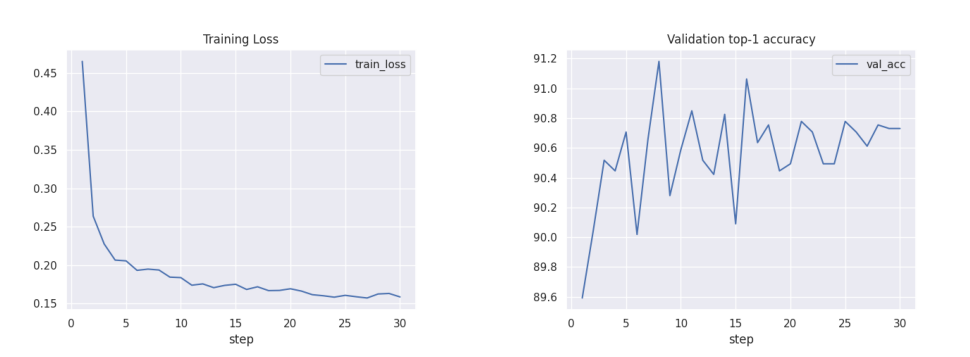

In [4]:
path_classifier = ut_val.get_path_classifier(root_model, dataset_classifier, params)
ut_val.move_classifier_out_file(path_classifier)

ut_val.load_classifier_plots(path_classifier)
create_run_md(path_folder)

#### Use pre computed embeddings for training

This means that no augmentation during training is possible.

In [13]:
classifier_training_call = f"CUDA_VISIBLE_DEVICES={cuda_device} nohup python main_linear.py"\
                          + " --batch_size 256 --batch_size_val 256 --epochs 30 --learning_rate 5"\
                          + f" --model {params['model']} --dataset {params['dataset']}"\
                          + f" --data_folder {os.path.join(path_embeddings, 'embedding_train')}"\
                          + f" --test_folder {os.path.join(path_embeddings, 'embedding_test')}"\
                          + " --num_classes 10 --pre_comp_feat"\
                          + f" --tag Epoch{epoch}"\
                          + (f" --md_file val_{dataset_val}.md" if params['dataset'] != dataset_val else "")\
                          + " > precomp_classifier.out"

if dataset_val_2:
    classifier_training_call_2 = f"CUDA_VISIBLE_DEVICES={cuda_device} nohup python main_linear.py"\
                            + " --batch_size 256 --batch_size_val 256 --epochs 30 --learning_rate 5"\
                            + f" --model {params['model']} --dataset {params['dataset']}"\
                            + f" --data_folder {os.path.join(path_embeddings_2, 'embedding_train')}"\
                            + f" --test_folder {os.path.join(path_embeddings_2, 'embedding_test')}"\
                            + " --num_classes 10 --pre_comp_feat"\
                            + f" --tag Epoch{epoch}"\
                            + (f" --md_file val_{dataset_val_2}.md" if params['dataset'] != dataset_val_2 else "")\
                            + " > precomp_classifier.out"

In [ ]:
os.system(classifier_training_call)

if dataset_val_2:
    os.system(classifier_training_call_2)

In [ ]:
path_classifier = ut_val.get_path_classifier(root_model, dataset_val, params)
ut_val.move_classifier_out_file(path_classifier)

ut_val.load_classifier_plots(path_classifier)

if dataset_val_2:
    path_classifier_2 = ut_val.get_path_classifier(root_model, dataset_val_2, params)
    ut_val.move_classifier_out_file(path_classifier_2)

    ut_val.load_classifier_plots(path_classifier_2)

### Dataloader and Model

In [9]:
train_loader, val_loader = ut_val.set_dataloader(dataset_val, params, root_train, root_test, aug_dict=aug_dict)
if dataset_val_2:
    train_loader_2, val_loader_2 = ut_val.set_dataloader(dataset_val_2, params, root_train_2, root_test_2, aug_dict=aug_dict_2)

model = ut_val.set_model(root_model, params, cuda_device)

### Compute Embedding

In [10]:
embedding_train, class_labels_train, images_train, embedding_test, class_labels_test, images_test = ut_val.compute_and_save_embeddings(model, train_loader, val_loader, path_embeddings, params, cuda_device)

if dataset_val_2:
    embedding_train_2, class_labels_train_2, images_train_2, embedding_test_2, class_labels_test_2, images_test_2 = ut_val.compute_and_save_embeddings(model, train_loader_2, val_loader_2, path_embeddings_2, params, cuda_device)

100%|██████████| 163/163 [00:48<00:00,  3.34it/s]


### t-SNE

Data split train
load feature embedding
compute t-SNE embedding
writ t-SNE embedding
Data split test
load feature embedding
compute t-SNE embedding
writ t-SNE embedding
Data split train
load feature embedding
compute t-SNE embedding
writ t-SNE embedding
Data split test
load feature embedding
compute t-SNE embedding
writ t-SNE embedding


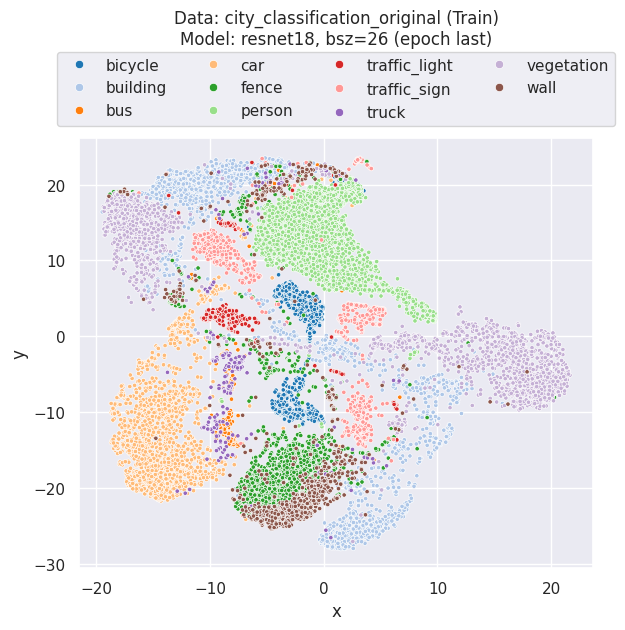

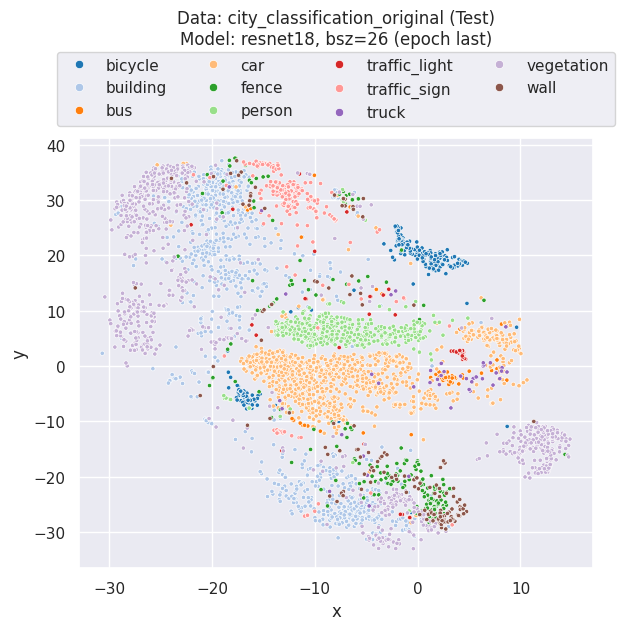

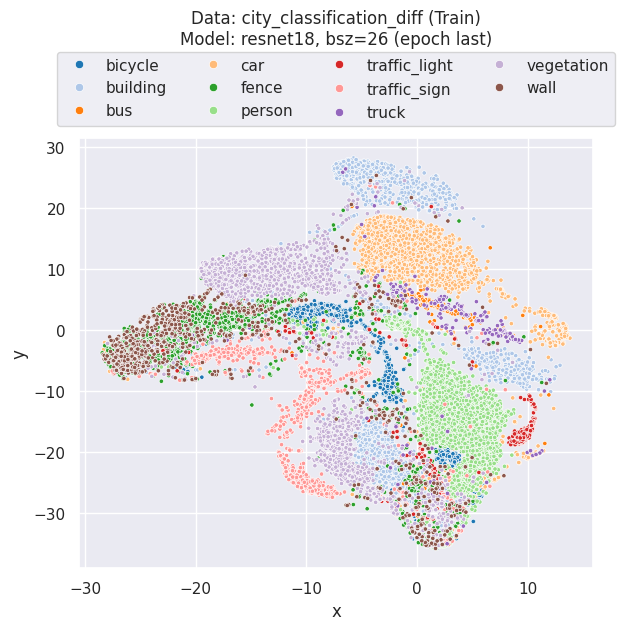

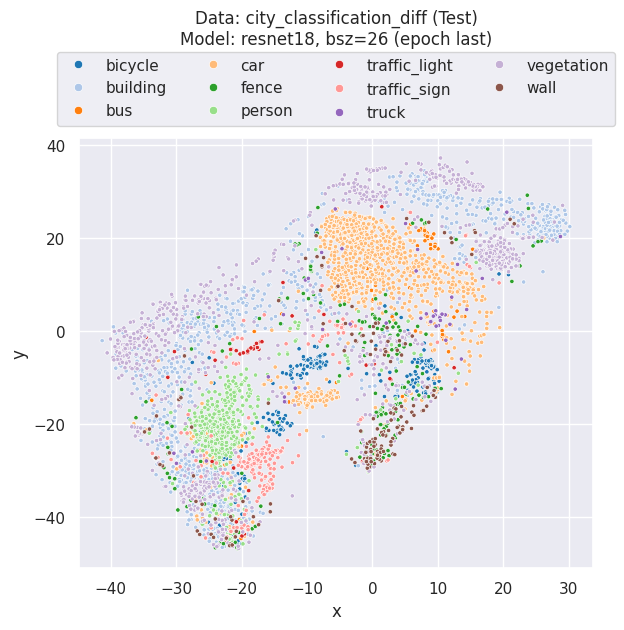

In [11]:
os.system(f"CUDA_VISIBLE_DEVICES={cuda_device} LD_LIBRARY_PATH={tsenecuda_venv_lib64} {tsenecuda_venv_interpreter} compute_tsne.py --path {path_embeddings}")
ut_val.save_tSNE_plots(dataset_val, path_embeddings, params, epoch)

if dataset_val_2:
    os.system(f"CUDA_VISIBLE_DEVICES={cuda_device} LD_LIBRARY_PATH={tsenecuda_venv_lib64} {tsenecuda_venv_interpreter} compute_tsne.py --path {path_embeddings_2}")
    ut_val.save_tSNE_plots(dataset_val_2, path_embeddings_2, params, epoch)

create_tsne_md(path_folder)

### Classifier individual Class Accuracies

city_classification_original
Train: acc=98.63, acc_b=96.23
 Test: acc=90.73, acc_b=85.39

city_classification_diff
Train: acc=96.17, acc_b=93.49
 Test: acc=82.34, acc_b=72.87


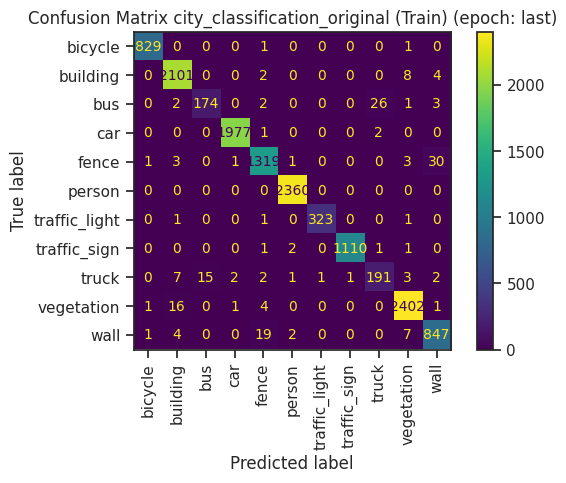

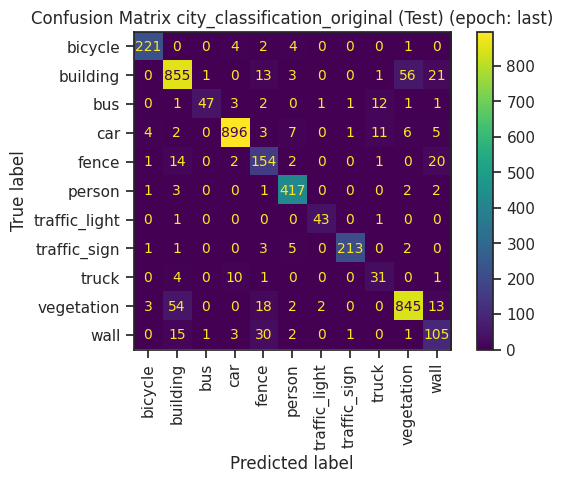

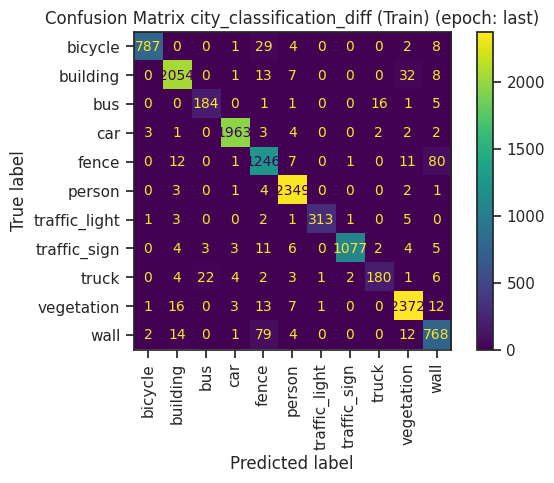

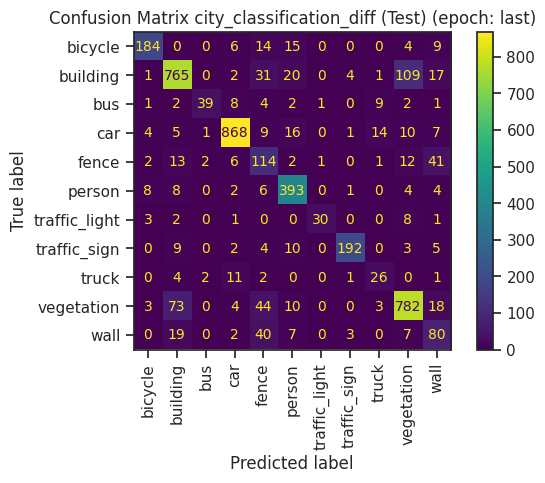

In [5]:
C_train, acc_train, acc_b_train, C_val, acc_val, acc_b_val = ut_val.compute_and_save_confusion_matrix(root_model, dataset_classifier, path_embeddings, params, epoch, cuda_device)

print(dataset_val)
if acc_train is not None and acc_b_train is not None:
    print(f"Train: acc={acc_train*100:.2f}, acc_b={acc_b_train*100:.2f}")
if acc_val is not None and acc_b_val is not None:
    print(f" Test: acc={acc_val*100:.2f}, acc_b={acc_b_val*100:.2f}")

if dataset_val_2:
    C_train_2, acc_train_2, acc_b_train_2, C_val_2, acc_val_2, acc_b_val_2 = ut_val.compute_and_save_confusion_matrix(root_model, dataset_classifier, path_embeddings_2, params, epoch, cuda_device)

    print(f"\n{dataset_val_2}")
    if acc_train_2 is not None and acc_b_train_2 is not None:
        print(f"Train: acc={acc_train_2*100:.2f}, acc_b={acc_b_train_2*100:.2f}")
    if acc_val_2 is not None and acc_b_val_2 is not None:
        print(f" Test: acc={acc_val_2*100:.2f}, acc_b={acc_b_val_2*100:.2f}")

create_cm_md(path_folder)

### Compute directly the Acc without precomputed embeddings

In [5]:
from networks.resnet_big import SupCEResNet

_, val_loader = ut_val.set_dataloader(dataset_val, params, root_train, root_test, aug_dict=aug_dict)

model = ut_val.set_model(root_model, params, cuda_device)

if "method" in params:
    path_classifier = ut_val.get_path_classifier(root_model=root_model, dataset_classifier=dataset_classifier, params=params)
    classifier = ut_val.load_classifier_checkpoint(path_classifier=path_classifier, model_name=params["model"],
                                                   num_classes=len(ut_val.get_classes(dataset_val)), cuda_device=cuda_device)

    model_classifier = SupCEResNet(name=params['model'], num_classes=len(ut_val.get_classes(dataset_val)))
    model_classifier = model_classifier.cuda(cuda_device)
    model_classifier.encoder = model.encoder
    model_classifier.fc = classifier.fc
else:
    model_classifier = model

In [7]:
df_pred_val = ut_val.get_predictions(classifier=model_classifier, data_loader=val_loader, cuda_device=cuda_device)

C_val = ut_val.get_confusion_matrix(df_pred_val)
acc_val, acc_b_val = ut_val.compute_accuracies(C_val)

# classes = ut_val.get_classes(dataset_val)
# ut_val.save_confusion_matrix(C_val, classes, title=f"Confusion Matrix {dataset_val} (Test) (epoch: {epoch})",
#                              path=os.path.join(*path_embeddings.split('/')[:-1], "cm", f"cm_val_epoch_{epoch}.png"))

print(f" Test: acc={acc_val*100:.2f}, acc_b={acc_b_val*100:.2f}")

 Test: acc=35.62, acc_b=31.89


**Dataset: animals10_diff_-1PatchSize30**

Patch Size | CE_diff_-1_allAug | SupCon_diff_-1_allAug | CE_diff_-1+4000_allAug | SupCon_diff_-1+4000_cAugSameSAug | SupCon_5.0_diff_-1+4000_cAugSameSAug_factor5
--|--|--|--|--|--
300 | acc=94.92, acc_b=94.32 | acc=95.02, acc_b=94.45 | acc=94.75, acc_b=94.04 | acc=94.96, acc_b=94.21 | acc=94.77, acc_b=94.11
150 | acc=92.57, acc_b=91.56 | acc=93.74, acc_b=93.05 | acc=91.92, acc_b=91.26 | acc=91.02, acc_b=90.51 | acc=90.76, acc_b=90.34
 75 | acc=84.93, acc_b=83.93 | acc=88.37, acc_b=87.43 | acc=81.86, acc_b=81.42 | acc=80.21, acc_b=80.73 | acc=76.20, acc_b=77.27
 50 | acc=65.99, acc_b=63.41 | acc=74.52, acc_b=73.13 | acc=64.17, acc_b=63.17 | acc=59.97, acc_b=60.51 | acc=54.37, acc_b=54.00
 30 | acc=35.37, acc_b=31.78 | acc=36.86, acc_b=32.15 | acc=30.75, acc_b=28.33 | acc=27.62, acc_b=23.45 | acc=25.84, acc_b=22.58
  1 | acc=18.49, acc_b=10.38 | acc=18.41, acc_b=10.00 | acc=18.41, acc_b=10.00 | acc=18.39, acc_b=9.99  | acc=19.73, acc_b=10.81

<br>

Patch Size | SupCon_100.0_animals10_diff_-1+4000_cAugSameSAug_fineTuneCAsameSAFactor100
--|--
300 | acc=93.05, acc_b=92.50
150 | acc=87.17, acc_b=87.33
 75 | acc=67.13, acc_b=68.40
 50 | acc=45.11, acc_b=43.61
 30 | acc=19.39, acc_b=15.92
  1 | acc=17.91, acc_b=10.20

**Dataset: animals10_diff_-1InnerPatchSize30** (uses `ShuffleInnerPatches` instead of `ShufflePatches`)

Patch Size | CE_diff_-1_allAug
--|--
30 | acc=35.62, acc_b=31.89